**Imports**

In [14]:
import os
import glob
import numpy as np
import SimpleITK as sitk
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
from monai.transforms import (
    Compose, LoadImageD, EnsureChannelFirstD, ScaleIntensityRangeD, RandRotateD,
    RandFlipD, ToTensorD
)
from monai.data import Dataset, DataLoader, CacheDataset
import monai
from PIL import Image
import nibabel as nib
import pandas as pd
import torch
from matplotlib.colors import ListedColormap
from tqdm import tqdm
import cv2
from monai.transforms import Transform

#!pip install nibabel

**Data Collection**

First we collect all the filepaths.

Then we create a dataframe to store all metadata

In [15]:
# Create a dataframe to store the patient number, frame number, the file path of the image, gt file path and whether it is a training or testing image

def parse_info_file(info_file_path):
    info_dict = {}
    with open(info_file_path, 'r') as file:
        for line in file:
            key, value = line.strip().split(': ')
            info_dict[key] = value if key == 'Group' else float(value) if '.' in value else int(value)
    return info_dict

def get_acdc_file_paths(data_paths):
    data_records = []
    
    for data_path, dataset_type in data_paths:
        # Get all the image and ground truth file paths
        image_pattern = os.path.join(data_path, 'patient*/patient*_frame??.nii.gz')
        gt_pattern = os.path.join(data_path, 'patient*/patient*_frame??_gt.nii.gz')
        image_paths = glob.glob(image_pattern)
        gt_paths = glob.glob(gt_pattern)

        # Convert gt_paths to a dictionary for quick lookup
        gt_dict = {os.path.basename(gt_path).replace('_gt', ''): gt_path for gt_path in gt_paths}

        for image_path in image_paths:
            basename = os.path.basename(image_path)
            patient_number = basename.split('_')[0].replace('patient', '')
            frame_number = basename.split('_')[1].replace('frame', '').replace('.nii.gz', '')

            # Extracting the directory path to read the info.cfg
            patient_dir = os.path.dirname(image_path)
            info_file_path = os.path.join(patient_dir, 'info.cfg')
            patient_info = parse_info_file(info_file_path)

            gt_path = gt_dict.get(basename, None)

            data_records.append({
                'patient_number': patient_number,
                'frame_number': frame_number,
                'image_path': image_path,
                'gt_path': gt_path,
                'dataset_type': dataset_type,
                **patient_info  # Add the info.cfg data to the record
            })

    # Create a DataFrame
    df = pd.DataFrame(data_records)

    return df

training_path = '../data/Training'
testing_path = '../data/Testing'

# Call the function with both paths and their dataset types
data_paths = [(training_path, 'Training'), (testing_path, 'Testing')]
df_metadata = get_acdc_file_paths(data_paths)

# Count the number of entries of each dataset type
counts = df_metadata['dataset_type'].value_counts()
print(counts)


dataset_type
Training    200
Testing     100
Name: count, dtype: int64


In [16]:
df_metadata.head(10)

,patient_number,frame_number,image_path,gt_path,dataset_type,ED,ES,Group,Height,NbFrame,Weight
0,001,01,../data/Training\patient001\patient001_frame01...,../data/Training\patient001\patient001_frame01...,Training,1,12,DCM,184.0,30,95.0
1,001,12,../data/Training\patient001\patient001_frame12...,../data/Training\patient001\patient001_frame12...,Training,1,12,DCM,184.0,30,95.0
2,002,01,../data/Training\patient002\patient002_frame01...,../data/Training\patient002\patient002_frame01...,Training,1,12,DCM,160.0,30,70.0
3,002,12,../data/Training\patient002\patient002_frame12...,../data/Training\patient002\patient002_frame12...,Training,1,12,DCM,160.0,30,70.0
4,003,01,../data/Training\patient003\patient003_frame01...,../data/Training\patient003\patient003_frame01...,Training,1,15,DCM,165.0,30,77.0
5,003,15,../data/Training\patient003\patient003_frame15...,../data/Training\patient003\patient003_frame15...,Training,1,15,DCM,165.0,30,77.0
6,004,01,../data/Training\patient004\patient004_frame01...,../data/Training\patient004\patient004_frame01...,Training,1,15,DCM,159.0,28,46.0
7,004,15,../data/Training\patient004\patient004_frame15...,../data/Training\patient004\patient004_frame15...,Training,1,15,DCM,159.0,28,46.0
8,005,01,../data/Training\patient005\patient005_frame01...,../data/Training\patient005\patient005_frame01...,Training,1,13,DCM,165.0,30,77.0
9,005,13,../data/Training\patient005\patient005_frame13...,../data/Training\patient005\patient005_frame13...,Training,1,13,DCM,165.0,30,77.0


In [19]:
list_training_image_paths = df_metadata[df_metadata['dataset_type'] == 'Training']['image_path'].tolist()
list_training_gt_paths = df_metadata[df_metadata['dataset_type'] == 'Training']['gt_path'].tolist()

list_testing_image_paths = df_metadata[df_metadata['dataset_type'] == 'Testing']['image_path'].tolist()
list_testing_gt_paths = df_metadata[df_metadata['dataset_type'] == 'Testing']['gt_path'].tolist()

**Investigate distribution of intensity values and apply histogram equalization**

In [20]:
from skimage import exposure

class HistogramEqualization(monai.transforms.Transform):
    def __call__(self, sample):
        image = sample['image']
        equalized_image = exposure.equalize_hist(image)  # Normalizes to [0, 1]

        sample['image'] = equalized_image * 255  # Optionally scale to [0, 255]
        return sample
    

In [61]:
from monai.transforms import (
    LoadImaged,
    EnsureChannelFirstd,
    SpacingD,
    Compose,
    MapTransform,
    ToTensorD,
)
from monai.data import Dataset, DataLoader

class Extract2DSlices(MapTransform):
    def __init__(self, keys, allow_missing_keys=False):
        super().__init__(keys, allow_missing_keys)

    def __call__(self, data):
        d = dict(data)
        slices_dict = {key: [] for key in self.keys}
        for key in self.keys:
            for i in range(d[key].shape[-1]):
                slice_2d = d[key][..., i]
                slice_meta = {f"{key}_meta_dict": d[f"{key}_meta_dict"].copy()}
                slices_dict[key].append({"image": slice_2d, "label": slice_meta["label"]})
        return slices_dict


# Define transformations
transforms = Compose([
    LoadImaged(keys=["image", "label"]),
    EnsureChannelFirstd(keys=["image", "label"]),
    SpacingD(keys=["image", "label"], pixdim=(1.0, 1.0, 1.0), mode="bilinear"),
    Extract2DSlices(keys=["image", "label"]),
    ToTensorD(keys=["image", "label"])
])

# Create your data dictionary
data_dicts = [{"image": image_path, "label": label_path} for image_path, label_path in zip(list_training_image_paths, list_training_gt_paths)]

# Create the dataset and dataloader
dataset = Dataset(data=data_dicts, transform=transforms)
dataloader = DataLoader(dataset, batch_size=1)

# Iterate through the dataloader
for batch in dataloader:
    for slice_data in batch['image']:
        print(f"Slice image shape: {slice_data['image'].shape}")
        print(f"Slice label shape: {slice_data['label'].shape}")
        print(f"Slice metadata: {slice_data['image_meta_dict']}")


RuntimeError: applying transform <monai.transforms.compose.Compose object at 0x0000021EF5AE9550>

In [71]:
from monai.transforms import LoadImage

data_dicts = [{"image": image_path, "label": label_path} for image_path, label_path in zip(list_training_image_paths, list_training_gt_paths)]
img_test = LoadImaged(keys=["image", "label"])(data_dicts[0])
# print(img_test['image'].meta.keys())
# print(img_test['image'].meta['affine'])
# print(img_test['image'].shape)
s = img_test['image'].shape
#print voxel spacing times shape to get total imgae size
print("Before spacingD:")
print(s[0]*img_test['image'].meta['affine'][0][0], s[1]*img_test['image'].meta['affine'][1][1])

#applly spacingD to the image
img_test = SpacingD(keys=["image", "label"], pixdim=(1.2, 1.0, None), mode="bilinear")(img_test)
#print(img_test['image'].meta['affine'])
s = img_test['image'].shape
#print voxel spacing times shape to get total imgae size
print("After spacingD:")
print(s[0]*img_test['image'].meta['affine'][0][0], s[1]*img_test['image'].meta['affine'][1][1])

# print(f"image data shape: {img_test}")
# print(f"meta data: {img_test.meta.keys()}")
# 
# #print voxel spacing
# print(f"voxel spacing: {img_test.meta['affine']}")

Before spacingD:
tensor(-337.5000, dtype=torch.float64) tensor(-400., dtype=torch.float64)
After spacingD:
tensor(-259.2000, dtype=torch.float64) tensor(-333., dtype=torch.float64)


In [ ]:
import torch
from monai.transforms import LoadImaged, SpacingD
from monai.data import Dataset, DataLoader

# Data loading
data_dicts = [{"image": image_path, "label": label_path} for image_path, label_path in zip(list_training_image_paths, list_training_gt_paths)]
img_test = LoadImaged(keys=["image", "label"])(data_dicts[0])

# Function to calculate real-world size
def calculate_real_world_size(shape, affine):
    spacing_x = affine[0][0]
    spacing_y = affine[1][1]
    real_world_size_x = shape[0] * spacing_x
    real_world_size_y = shape[1] * spacing_y
    return real_world_size_x, real_world_size_y

# Before SpacingD
print("Before SpacingD:")
shape_before = img_test['image'].shape
affine_before = img_test['image'].meta['affine']
real_world_size_before = calculate_real_world_size(shape_before, affine_before)
print(f"Shape: {shape_before}")
print(f"Affine: {affine_before}")
print(f"Real-world size: {real_world_size_before}")

# Apply SpacingD
img_test = SpacingD(keys=["image", "label"], pixdim=(0.2, 0.2, None), mode="bilinear")(img_test)

# After SpacingD
print("After SpacingD:")
shape_after = img_test['image'].shape
affine_after = img_test['image'].meta['affine']
real_world_size_after = calculate_real_world_size(shape_after, affine_after)
print(f"Shape: {shape_after}")
print(f"Affine: {affine_after}")
print(f"Real-world size: {real_world_size_after}")

# Difference in real-world size
print("Difference in real-world size:")
print(f"X-axis: {real_world_size_after[0] - real_world_size_before[0]}")
print(f"Y-axis: {real_world_size_after[1] - real_world_size_before[1]}")


In [81]:
# Patch size, should be divisible by 2 repeatedly for UNet
size_y = 128
size_x = 128 

# TODO: probably change which transforms to take

class ConvertToFloat32:
    def __call__(self, sample):
        sample['image'] = sample['image'].astype(np.float32)
        sample['label'] = sample['label'].astype(np.float32)
        return sample

train_transform = monai.transforms.Compose([ #composed of several transforms
    LoadData(keys=['image', 'label']),
    HistogramEqualization(),
    #monai.transforms.EnsureChannelFirstD(keys=['image', 'label']),
    monai.transforms.SpacingD(keys=['image', 'label'], pixdim=(1.3, 1.3, None), mode=['bilinear', 'nearest']),
    monai.transforms.RandRotateD(keys=['image', 'label'], range_x=2*3.1415, prob=0.5, mode=['bilinear', 'nearest']), # Rotate up to 360 degrees
    monai.transforms.RandFlipD(keys=['image', 'label'], spatial_axis=0, prob=0.25), # Flip along x-axis
    monai.transforms.RandFlipD(keys=['image', 'label'], spatial_axis=1, prob=0.25), # Flip along y-axis
    monai.transforms.RandSpatialCropd(keys=['image', 'label'], roi_size=[size_x, size_y], random_size=False), # Crop patch
    monai.transforms.ToTensorD(keys=['image', 'label'])
])

val_transform = monai.transforms.Compose([
    LoadData(keys=['image', 'label']),
    HistogramEqualization(),
    ConvertToFloat32(),
    monai.transforms.RandSpatialCropd(keys=['image', 'label'], roi_size=[size_x, size_y], random_size=False),
    monai.transforms.ToTensorD(keys=['image', 'label'])
])

train_dataset = Dataset(data=training_slices_dict, transform=train_transform)
test_dataset = Dataset(data=testing_slices_dict, transform=val_transform)

batch_size = 1
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

tensor([[1.6406, 1.6406]])


C:\Users\gijsd\anaconda3\Lib\site-packages\monai\transforms\spatial\array.py:494: UserWarning: `data_array` is not of type MetaTensor, assuming affine to be identity.
  warnings.warn("`data_array` is not of type MetaTensor, assuming affine to be identity.")


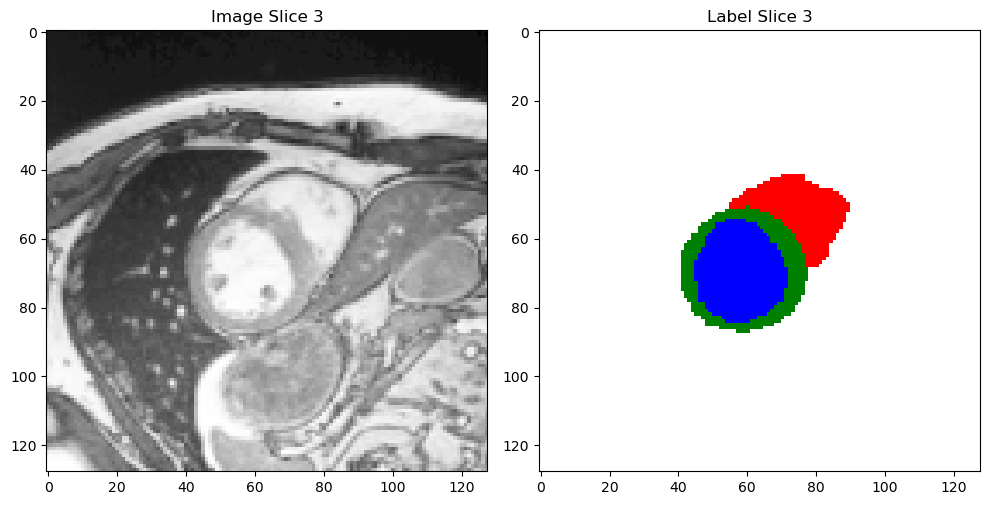

In [82]:
label_cmap = ListedColormap(['none', 'red', 'green', 'blue'])

def visualize_single_sample(data_loader):
    data_batch = next(iter(data_loader))
    batch_index = 0
    image, label = data_batch['image'][batch_index], data_batch['label'][batch_index]
    slice_number = data_batch['image_meta_dict']['slice_number'][batch_index]
    
    #PRINT PIXEL SPACING
    print(data_batch['image_meta_dict']['pixdim'])
    
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(image[0].numpy(), cmap="gray")
    axes[0].set_title(f"Image Slice {slice_number}")
    axes[1].imshow(label[0].numpy(), cmap=label_cmap)
    axes[1].set_title(f"Label Slice {slice_number}")
    plt.tight_layout()
    plt.show()

# Visualize a single sample from the training loader
visualize_single_sample(train_loader)

Setting up the UNet model

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'The used device is {device}')

The used device is cuda


In [12]:
model = monai.networks.nets.UNet( #default kernel size is 3
    spatial_dims=2,
    in_channels=1,
    out_channels=4,
    channels=(16, 32, 64, 128),
    strides=(2, 2, 2),
    num_res_units=2,
    kernel_size=5,  
    up_kernel_size=5
).to(device)
#TODO: Try different parameters

In [13]:
import wandb

wandb.login()

wandb: Currently logged in as: gijsdesmit (gijsds). Use `wandb login --relogin` to force relogin


True

In [20]:
def from_compose_to_list(compose_obj):
    return [str(transform) for transform in compose_obj.transforms]

run_name = 'Third_Run'
run = wandb.init(project='Project - UNet',
                 name=run_name, 
                 config={'dataset': 'ACDC',
                         'model': 'UNet',
                         'loss function': 'DiceLoss',
                         'optimizer': 'Adam',
                         'transform': from_compose_to_list(train_transform),
                         'batch size': batch_size})

run_id = run.id

In [21]:
def wandb_masks(mask_output, mask_gt):
    """ Function that generates a mask dictionary in format that W&B requires """

    # Transform masks to numpy arrays on CPU
    mask_output = mask_output.squeeze().detach().cpu().numpy()
    mask_gt = mask_gt.squeeze().detach().cpu().numpy()

    # Create mask dictionary with class labels and insert masks
    class_labels = {0: 'background', 1: 'class1', 2: 'class2', 3: 'class3'}
    masks = {
        'predictions': {'mask_data': mask_output, 'class_labels': class_labels},
        'ground truth': {'mask_data': mask_gt, 'class_labels': class_labels}
    }
    return masks

def log_to_wandb(epoch, train_loss, val_loss, batch_data, outputs):
    """ Function that logs ongoing training variables to W&B """

    # Apply softmax and argmax to the model output
    softmax = torch.nn.Softmax(dim=1)
    outputs = softmax(outputs)
    outputs = torch.argmax(outputs, dim=1)  # Change to dim=1 for batch processing

    # Create list of images that have segmentation masks for model output and ground truth
    log_imgs = [
        wandb.Image(
            img.cpu().numpy().transpose(1, 2, 0),  # Ensure images are in (H, W, C) format
            masks=wandb_masks(mask_output, mask_gt)
        )
        for img, mask_output, mask_gt in zip(batch_data['image'], outputs, batch_data['label'])
    ]

    # Send epoch, losses and images to W&B
    wandb.log({'epoch': epoch, 'train_loss': train_loss, 'val_loss': val_loss, 'results': log_imgs})



In [16]:
#loss_function =  monai.losses.DiceLoss(sigmoid=True, batch=True)
import torch.nn as nn

# class CombinedLoss(nn.Module):
#     def __init__(self, dice_weight=0.5):
#         super(CombinedLoss, self).__init__()
#         self.dice_weight = dice_weight
#         self.dice_loss = monai.losses.DiceLoss(to_onehot_y=True, softmax=True)
#         self.ce_loss = nn.CrossEntropyLoss()
# 
#     def forward(self, outputs, targets):
#         dice_loss = self.dice_loss(outputs, targets)
#         ce_loss = self.ce_loss(outputs, torch.argmax(targets, dim=1))
#         return self.dice_weight * dice_loss + (1 - self.dice_weight) * ce_loss
# 
# # Usage
# loss_function = CombinedLoss(dice_weight=0.5)

# loss_function =  monai.losses.DiceLoss(sigmoid=True, batch=True)
loss_function = monai.losses.DiceLoss(to_onehot_y=True, softmax=True) #TODO: potentially change this, look for different loss metrics

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [22]:
start_epoch = 0
n_epochs = 102

for epoch in range(start_epoch, n_epochs):
    model.train()
    train_loss = 0
    for batch_data in tqdm(train_loader):
        inputs = batch_data['image'].to(device)
        masks = batch_data['label'].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, masks)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(train_loader)

    # Validation
    model.eval()
    val_loss = 0
    for batch_data in val_loader:
        inputs = batch_data['image'].to(device)
        masks = batch_data['label'].to(device)
        
        outputs = model(inputs)
        loss = loss_function(outputs, masks)
        val_loss += loss.item()
        
       
    val_loss /= len(val_loader)
    
    log_to_wandb(epoch, train_loss, val_loss, batch_data, outputs)

# Store the network parameters        
torch.save(model.state_dict(), 'trainedUNet' + run_name + '.pt')

100%|██████████| 476/476 [00:20<00:00, 23.66it/s]


In [23]:
run.finish()

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
train_loss,▆█▇▆▆▃▆▄▅▄▄▅▃▆▄▃▄▂█▄▃▁▃▃▄▃▁▃▃▃▃▃▄▇▄▃▂▂▃▂
val_loss,▃▅▄▃▄▃▅▃▄▄▃▂▂▆▆▂▃▄▂▃▂▂▃▂▄▃▂▅▂▁▂▃▅█▂▂▂▂▃▃
epoch,100
train_loss,0.20954
val_loss,0.22007


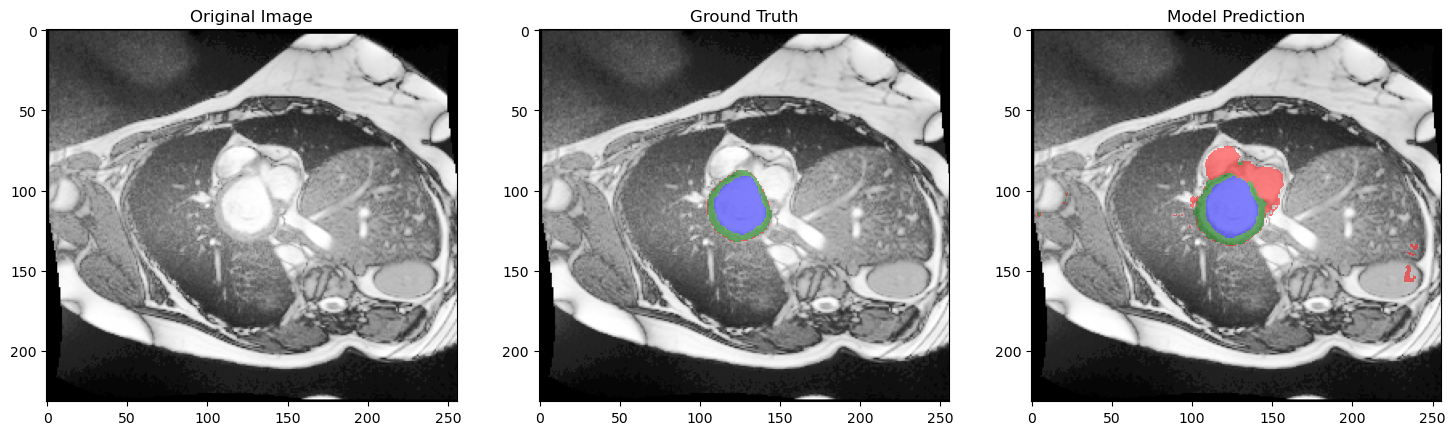

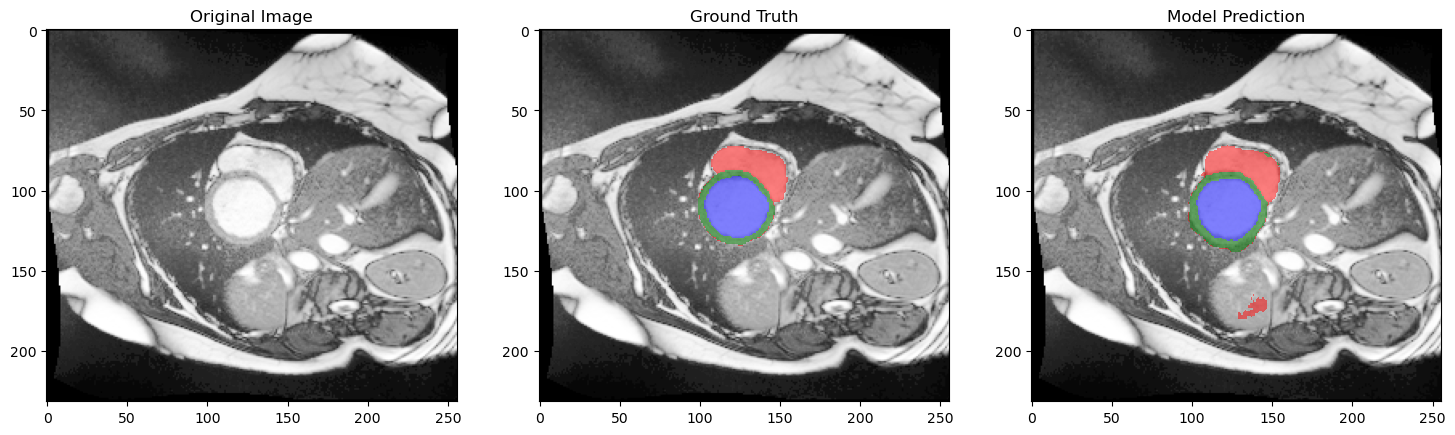

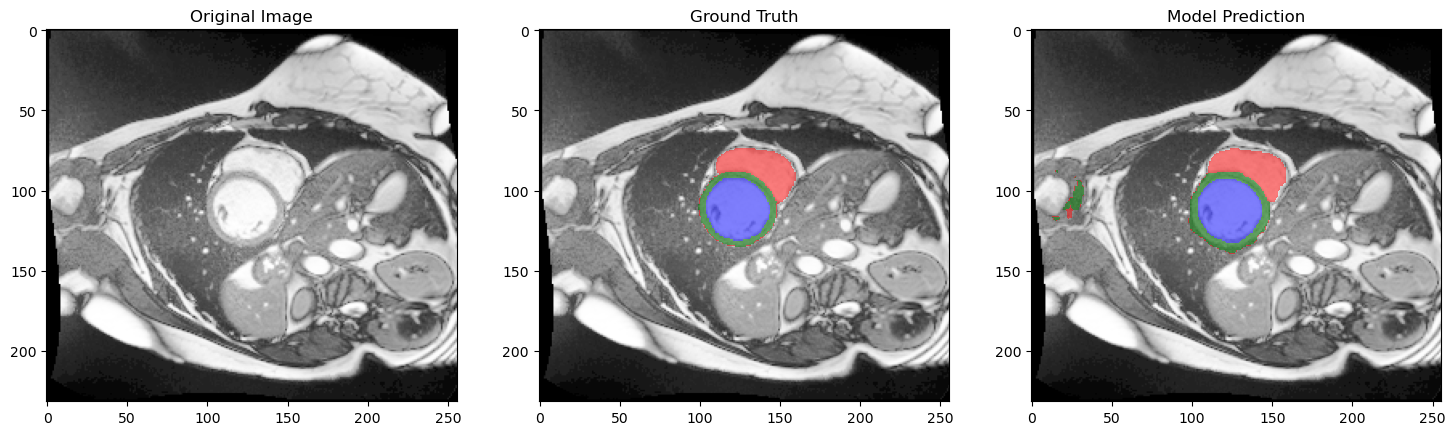

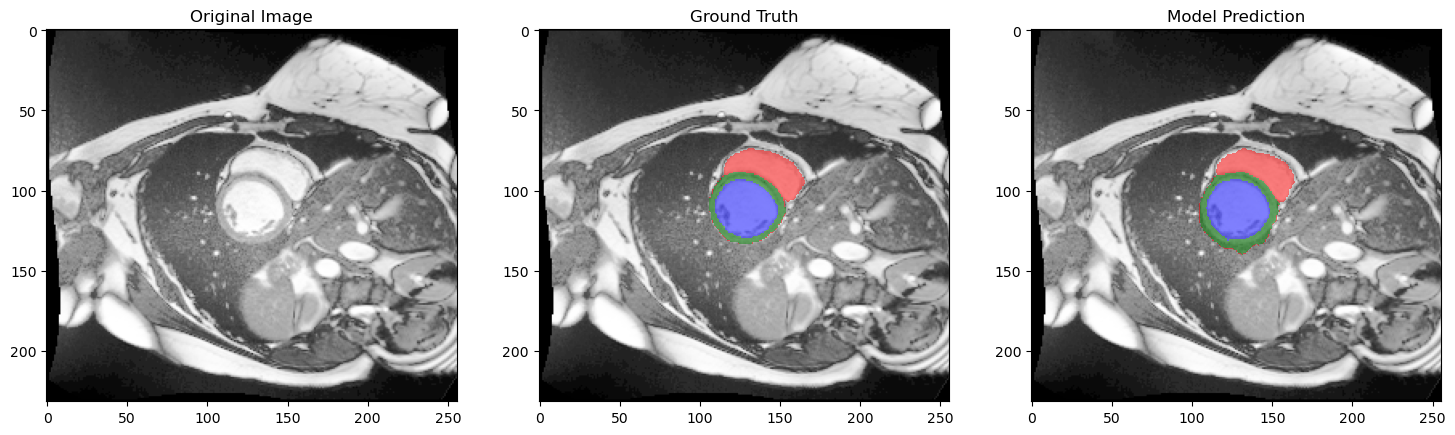

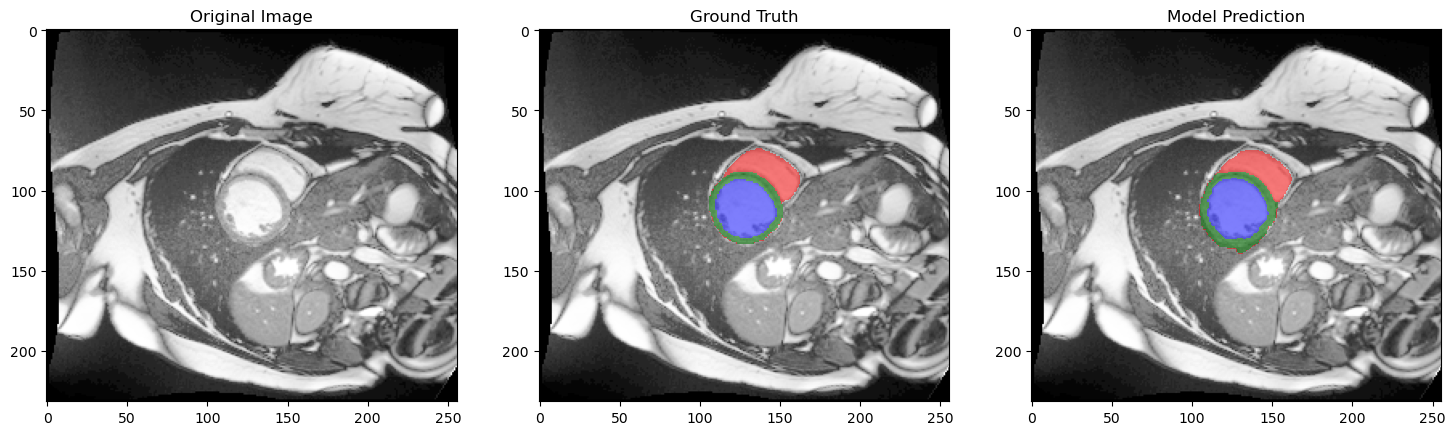

In [24]:
def visual_evaluation(sample, model):
    """
    Allow the visual inspection of one sample by plotting the image, the ground truth,
    and the segmentation map produced by the network.
    
    Args:
        sample (Dict[str, torch.Tensor]): sample composed of an image ('image') and a mask ('label').
        model (torch.nn.Module): trained model to evaluate.
    """
    model.eval()
    inferer = monai.inferers.SlidingWindowInferer(roi_size=[size_x, size_y]) 
    softmax = torch.nn.Softmax(dim=1)

    # Ensure the input is float32
    sample_image = sample['image'].to(device)
    #check if image is float or double
    #print(sample_image.dtype)

    with torch.no_grad():
        output = softmax(inferer(sample_image, network=model)).squeeze()

    # Convert the ground truth and prediction to the format suitable for visualization
    #torch.Size([1, 1, 232, 256])
    #convert to 232, 256
    ground_truth = sample['label'].squeeze().numpy()
    #ground_truth = torch.argmax(sample['label'].squeeze(), dim=0).numpy()
    predicted_label = torch.argmax(output, dim=0).cpu().numpy()

    fig, ax = plt.subplots(1, 3, figsize=[18, 6])

    # Plot original image
    ax[0].imshow(sample['image'].squeeze().numpy(), cmap='gray')
    ax[0].set_title('Original Image')

    # Plot ground truth
    ax[1].imshow(sample['image'].squeeze().numpy(), cmap='gray')
    ax[1].imshow(ground_truth, cmap=label_cmap, alpha=0.5)
    ax[1].set_title('Ground Truth')

    # Plot model prediction
    ax[2].imshow(sample['image'].squeeze().numpy(), cmap='gray')
    ax[2].imshow(predicted_label, cmap=label_cmap, alpha=0.5)
    ax[2].set_title('Model Prediction')

    plt.show()

test_transform = monai.transforms.Compose([
    LoadData(keys=['image', 'label']),
    HistogramEqualization(),
    ConvertToFloat32(),
    monai.transforms.ToTensorD(keys=['image', 'label'])
])

test_dataset = Dataset(data=testing_slices_dict, transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=1)

i = 0
for sample in test_loader:
    visual_evaluation(sample, model)
    i += 1
    if i == 5:
        break


In [19]:
#TODO: Evaluation metrics (which ones) of the whole test set ofc ....